In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
%matplotlib notebook
%matplotlib inline

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH

%aimport models.AEFIT5
%aimport models.Compose

# ipysh.Bootstrap_support.debug()


import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       




/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


Using TensorFlow backend.


# TEST QSH


In [2]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean.npy'
try: qsh.load(file)
except: raise FileNotFoundError
    
qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F'])
# qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm'])
# qsh.unbias_mean(0.5, 'te')
# qsh.set_normal_positive(['te'])
# qsh.clip_values(0.1,0.6)
# qsh.set_normal_positive(['te'])


print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [3]:
Br_min, Br_max = np.nanmin(qsh['Br_rm']), np.nanmax(qsh['Br_rm'])
def _map(xy,p,Br):
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    return (xy,pBr),(xy,pBr)
# ds = qsh.tf_tuple_compose(['prel','te','tbordo~tcentro~Ip~NS~VT~F','absBt_rm~argBt_rm']).map(lambda x,y,t,s: (_map(x,y,t,s)) )
# ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm']).map(lambda x,y,z: _map(x,y,z) )
ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','Br_rm']).map(lambda x,y,z: _map(x,y,z) )
# [x for x in ds.shuffle(100).batch(1).take(1)][0]

W0902 16:33:34.006211 140306362611520 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [4]:
m1 = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=30,  dprate=0., scale=1, geometry=[20,20,10,10], beta=0.) #beta=0.001)
m2 = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=24,  dprate=0., scale=1, beta=0., name='parameters', geometry=[20,20,10,10]) # parameters

AEFIT5 a ready:
AEFIT5 a ready:
AEFIT5 a ready:
[(None, 30), (None, 24)]


In [50]:
hm_feature_dim = m1.latent_dim + m2.latent_dim
hm = models.AEFIT5.AEFIT5(latent_dim=10, feature_dim=hm_feature_dim, beta=0., scale=1, name='hidden', geometry=[10,20,20,10])
h = models.Compose.Compose().set_model(hm).compose([m1,m2])

AEFIT5 a ready:
[(None, 30), (None, 24)]


In [5]:
ds_m1 = qsh.tf_tuple_compose(['prel~te:15']).map(lambda x: (x,x) )
m1.compile( m1.optimizer, tf.losses.mse ) 
# m1.compile( ) 
# models.base.train_thread(m1, ds_m1, batch=100, epoch=50, callbacks=[]).control_panel()
history = m1.fit( ds_m1.skip(5000).batch(100).take(100), validation_data=ds_m1.take(5000).batch(100), epochs=30 )

Epoch 1/30
100/100 [==============================] - 5s 51ms/step - loss: 0.0144 - val_loss: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 3s 31ms/step - loss: 0.0010 - val_loss: 4.4006e-04
Epoch 3/30
100/100 [==============================] - 3s 31ms/step - loss: 3.9869e-04 - val_loss: 4.0692e-04
Epoch 4/30
100/100 [==============================] - 3s 31ms/step - loss: 4.0567e-04 - val_loss: 5.7167e-04
Epoch 5/30
100/100 [==============================] - 3s 31ms/step - loss: 4.0514e-04 - val_loss: 4.7666e-04
Epoch 6/30
100/100 [==============================] - 3s 32ms/step - loss: 4.0440e-04 - val_loss: 4.1735e-04
Epoch 7/30
100/100 [==============================] - 3s 32ms/step - loss: 4.3031e-04 - val_loss: 4.0857e-04
Epoch 8/30
100/100 [==============================] - 3s 32ms/step - loss: 4.1309e-04 - val_loss: 4.0764e-04
Epoch 9/30
100/100 [==============================] - 3s 31ms/step - loss: 4.3472e-04 - val_loss: 4.0537e-04
Epoch 10/30
100/100 [======

In [7]:
qsh.dim = None
p = Hplt.LSPlotBokeh()
p.set_model(m1)
p.set_data(qsh, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

# m1.save('step12_m1_compose')
# m1.load('step12_m1_compose')

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [9]:
def m2_map(p,Br):
    Br = (Br-Br_min)/(Br_max-Br_min)
    pBr = tf.concat([p,Br], axis=0)
    return pBr,pBr
ds_m2 = qsh.tf_tuple_compose(['Ip~NS~VT~F','Br_rm']).map(lambda x,y: m2_map(x,y) )
m2.compile( m2.optimizer, tf.losses.mse )
# models.base.train_thread(m2, ds_m2, batch=100, epoch=10, callbacks=[]).control_panel()
m2.fit( ds_m2.skip(5000).batch(100).take(100), validation_data=ds_m2.take(5000).batch(100), epochs=30)

Epoch 1/30
100/100 [==============================] - 7s 70ms/step - loss: 0.0404 - val_loss: 0.0000e+00
Epoch 2/30
100/100 [==============================] - 6s 60ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 3/30
100/100 [==============================] - 6s 60ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 4/30
100/100 [==============================] - 6s 61ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/30
100/100 [==============================] - 6s 61ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/30
100/100 [==============================] - 6s 61ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/30
100/100 [==============================] - 6s 62ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/30
100/100 [==============================] - 6s 61ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/30
100/100 [==============================] - 6s 64ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/30
100/100 [==============================] - 6s 63ms/step - loss: 0.0022 - va

In [53]:
m1.trainable = False
m2.trainable = False
hm.trainable = True
h.loss_weights = [0.9,0.1]

# l1 = tf.keras.regularizers.l1
# l2 = tf.keras.regularizers.l2
# for n in [hm.inference_net, hm.generative_net]:
#     for l in n.layers:
#         if issubclass(type(l), tf.keras.layers.Dense):
#             l.activity_regularizer = l1(0.01)
            
# h.compile( h.optimizer, tf.losses.mse )
h.compile( )

In [54]:
# hm.beta = 1.
# h.compile()
# models.base.train_thread(h, ds.take(10000) , epoch=100, batch=100, learning_rate=1e-3, callbacks=[PlotLossesCallback()]).control_panel()
h.fit( ds.skip(5000).batch(100).take(100), validation_data=ds.take(5000).batch(100), epochs=200)

Epoch 1/200
100/100 [==============================] - 13s 135ms/step - loss: 0.0026 - output_1_loss: 3.5914e-04 - output_2_loss: 0.0022 - val_loss: 0.0000e+00 - val_output_1_loss: 0.0000e+00 - val_output_2_loss: 0.0000e+00
Epoch 2/200
100/100 [==============================] - 8s 79ms/step - loss: 0.0024 - output_1_loss: 3.6067e-04 - output_2_loss: 0.0021 - val_loss: 0.0023 - val_output_1_loss: 3.3101e-04 - val_output_2_loss: 0.0020
Epoch 3/200
100/100 [==============================] - 8s 78ms/step - loss: 0.0023 - output_1_loss: 3.2640e-04 - output_2_loss: 0.0020 - val_loss: 0.0024 - val_output_1_loss: 2.7888e-04 - val_output_2_loss: 0.0022
Epoch 4/200
100/100 [==============================] - 8s 80ms/step - loss: 0.0024 - output_1_loss: 3.2478e-04 - output_2_loss: 0.0021 - val_loss: 0.0025 - val_output_1_loss: 3.0140e-04 - val_output_2_loss: 0.0022
Epoch 5/200
100/100 [==============================] - 8s 79ms/step - loss: 0.0025 - output_1_loss: 3.6968e-04 - output_2_loss: 0.0022

KeyboardInterrupt: 

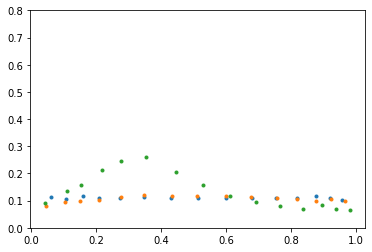

In [65]:
# [ v.name for v in h2.trainable_variables ]
def plot(xy):
    plt.figure('data')
    ax = plt.gca()
    ax.set_ylim(0.,.8)
    x,y = tf.split(xy[0], num_or_size_splits=2)
    plt.plot(x,y,'.')
d = [x for x in ds.shuffle(100).batch(1).take(100)][0]
d0 = d[0][0]

xy = d[0][0]
XY = m1(xy, training=False)
plot(xy)
plot(XY)

d_param = d[0]
d_param = ( tf.zeros_like(d[0][0]), d[0][1] ) # spengo SXR e tengo i parametri
# y0 = h(d[0], training=False)
y0 = h(d_param, training=False)[0]
# y0 = tf.sigmoid(y0)
# plot(d0)
plot(y0)



In [ ]:
# tbordo tcentro Ip NS VT F
xy,_ =  [x for x in ds.batch(1).take(1)][0]
par = xy[2]

l,_ = h.encode(xy, training=False)
XY  = h.decode(l, training=False, apply_sigmoid=True) 
PAR = XY[2]

print( list(zip(par, PAR)) )


In [ ]:
fig = plt.figure('test_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.)

# sx = []
# sy = []
# for xy in ds.batch(1).take(1000):
#     xy,_ = xy
#     x,y = tf.split(xy[0],2, axis=1)
#     me,_  = h.encode(xy, training=False)
#     gpt = me[0].numpy()
#     #ax1.scatter(gpt[0],gpt[1])
#     sx.append(gpt[0])
#     sy.append(gpt[1])

# ax1.scatter(sx,sy)
    
for xy in ds.shuffle(100).batch(1).take(1):    
    xy,_ = xy
    x,y = tf.split(xy[0],2, axis=1)
    ax2.scatter(x,y,s=80)
    me,_  = h.encode(xy, training=False)
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = h.decode(me, training=False)[0]
    XY = tf.sigmoid(XY)
    X,Y = tf.split(XY[0], num_or_size_splits=2)
    X,Y = (X.numpy(), Y.numpy())
    ax2.scatter(X,Y,s=40)

print(qsh_pos)    
qsh_pos += 1

In [ ]:
xy,_ = [x for x in ds.batch(2).take(1)][0]
me,va = h.encode(xy)
XY = h.decode(me, apply_sigmoid=True)
XY[0][0]